TODO: code opkuisen

## imports and setting up the environment

In [93]:
import pyannote
import torch
from pathlib import Path
import shutil

# database related imports
from pyannote.database import registry, FileFinder

# training related imports
from pyannote.audio import Pipeline, Model
from pyannote.audio.pipelines import SpeakerDiarization
from pyannote.audio.tasks import Segmentation
from pyannote.pipeline import Optimizer
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    RichProgressBar,
)
from types import MethodType
from torch.optim import Adam

# metrics related imports
from pyannote.metrics.diarization import DiarizationErrorRate

# other
import os

huggingface_token = os.getenv("HUGGINGFACE_TOKEN")


## Data preparation

In [94]:
registry.load_database("database_v3.yml")

protocol = registry.get_protocol("BP.SpeakerDiarization.VlaamseAudio", {"audio":FileFinder()})

for file in protocol.train():
   assert "annotation" in file
   assert isinstance(file["annotation"], pyannote.core.Annotation)
   assert "annotated" in file
   assert isinstance(file["annotated"], pyannote.core.Timeline)

for file in protocol.test():
   assert "annotation" in file
   assert isinstance(file["annotation"], pyannote.core.Annotation)
   assert "annotated" in file
   assert isinstance(file["annotated"], pyannote.core.Timeline)

for file in protocol.development():
   assert "annotation" in file
   assert isinstance(file["annotation"], pyannote.core.Annotation)
   assert "annotated" in file
   assert isinstance(file["annotated"], pyannote.core.Timeline)


/home/lisa_verhoeyen/.local/lib/python3.10/site-packages/pyannote/database/registry.py:499: UserWarning: Replacing existing BP.SpeakerDiarization.VlaamseAudio protocol by the one defined in '/mnt/c/Users/verho/Documents/School/2024-2025/Bacherlorproef/bp-stemmen-onderscheiden/pyannote/database_v3.yml'.
  warnings.warn(


In [95]:
database = registry.get_database("BP")

database.get_tasks()

['SpeakerDiarization']

## pretrained pyannote pipeline

In [96]:
# get the model from the pipeline

pretrained_pipeline = Pipeline.from_pretrained(Path("./pipeline/config.yaml"))


current error rate of the pipeline (possibly very slow)

In [97]:
metric = DiarizationErrorRate()

for file in protocol.test():
    print(file)
    file["pretrained pipeline"] = pretrained_pipeline(file)
    metric(file["annotation"], file["pretrained pipeline"], uem=file["annotated"])

print(f"Diarization error rate is {100 * abs(metric):.1f}% for the pretrained model")

/home/lisa_verhoeyen/.local/lib/python3.10/site-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  std = sequences.std(dim=-1, correction=1)


Diarization error rate is 23.4% for the pretrained model


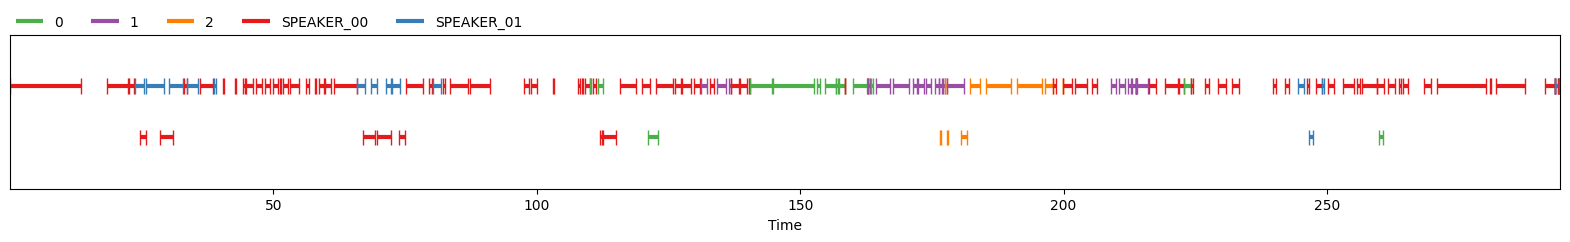

In [98]:
file["pretrained pipeline"]

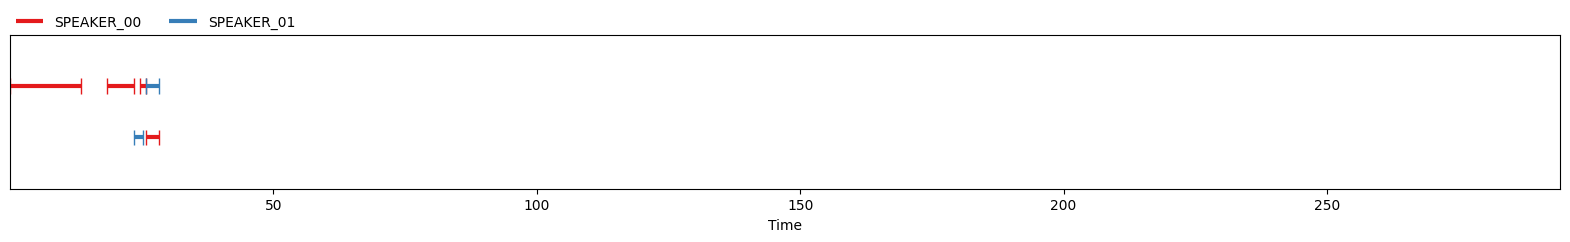

In [99]:
file["annotation"]

## train the model

In [100]:
pretrained_segm_model = Model.from_pretrained("./pipeline/segmentation/pytorch_model.bin")
output_dir = "./models"

task = pyannote.audio.tasks.SpeakerDiarization(
    protocol,
    max_num_speakers=5,
    batch_size=32,
    vad_loss="bce"
)

Protocol BP.SpeakerDiarization.VlaamseAudio does not precompute the output of torchaudio.info(): adding a 'torchaudio.info' preprocessor for you to speed up dataloaders. See pyannote.database documentation on how to do that yourself.


/home/lisa_verhoeyen/.local/lib/python3.10/site-packages/pyannote/audio/tasks/segmentation/speaker_diarization.py:176: UserWarning: `max_num_speakers` has been deprecated in favor of `max_speakers_per_chunk`.
  warnings.warn(


In [101]:
pretrained_segm_model.task = task
pretrained_segm_model.prepare_data()
pretrained_segm_model.setup()

/home/lisa_verhoeyen/.local/lib/python3.10/site-packages/pyannote/audio/core/model.py:229: UserWarning: Model has been trained for a different task. For fine tuning or transfer learning, it is recommended to train task-dependent layers for a few epochs before training the whole model: ['activation', 'classifier'].
  warnings.warn(msg)


In [102]:
def configure_optimizers(self):
    return Adam(self.parameters(), lr=1e-4)


In [103]:
pretrained_segm_model.configure_optimizers = MethodType(configure_optimizers, pretrained_segm_model)

In [104]:
monitor, direction = task.val_monitor
checkpoint = ModelCheckpoint(
    monitor,
    mode=direction,
    save_top_k=1,
    every_n_epochs=1,
    save_last=False,
    save_weights_only=False,
    filename="{epoch}",
    verbose=False
)

In [105]:
early_stopping = EarlyStopping(
    monitor=monitor,
    mode=direction,
    min_delta=0.0,
    patience=10,
    strict=True,
    verbose=False
)

In [106]:
callbacks = [RichProgressBar(), checkpoint, early_stopping]

In [107]:
trainer = pl.Trainer(
    callbacks=callbacks,
    max_epochs=50,
    gradient_clip_val=0.5,
    log_every_n_steps=5
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [108]:
trainer.fit(pretrained_segm_model)

/home/lisa_verhoeyen/.local/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /mnt/c/Users/verho/Documents/School/2024-2025/Bacherlorproef/bp-stemmen-onderscheiden/pyannote/DiarizationErrorRate exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   ┃ Name              ┃ Type             ┃ Params ┃ Mode  ┃      In sizes ┃                           Out sizes ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 0 │ sincnet           │ SincNet          │ 42.6 K │ train │ [1, 1, 32000] │                        [1, 60, 115] │
│ 1 │ lstm              │ LSTM             │  1.4 M │ train │  [1, 115, 60] │   [[1, 115, 256], [[8, 1, 128], [8, │
│   │                   │                  │        │       │               │                           1, 128]]] │
│ 2 │ linear            │ ModuleList       │ 49.4 K │ train │             ? │                                   ? │
│ 3 │ classifier        │ Linear           │    645 │ train │ [1, 115, 128] │                         [1, 115, 5] │
│ 4 │ activation        │ Sigmoid          │      0 │ train │   [1, 115, 5] │                         [1, 115, 5] │
│ 5 │ validation_metric │ MetricCollection │      0 │ train │             ? │                                   ? │
└───┴───────────────────┴──────────────────┴────────┴───────┴───────────────┴─────────────────────────────────────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 27                                                                                          
Modules in eval mode: 0

Output()

/home/lisa_verhoeyen/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:123: Your 
`IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), 
`__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.

In [109]:
trained_model = checkpoint.best_model_path


In [110]:
trained_model

'/mnt/c/Users/verho/Documents/School/2024-2025/Bacherlorproef/bp-stemmen-onderscheiden/pyannote/DiarizationErrorRate/epoch=46.ckpt'

In [111]:
# copy the model to a more accessible file
shutil.copy(trained_model, "./models/trained_model.ckpt")

'./models/trained_model.ckpt'

## finetuning

In [112]:
pipeline = SpeakerDiarization(
    segmentation=trained_model,
    clustering="OracleClustering"
)

In [113]:
pipeline.freeze({"segmentation": {"min_duration_off": 0.0}})

In [114]:
optimizer = Optimizer(pipeline)
dev_set = list(protocol.development())

In [115]:
iterations = optimizer.tune_iter(dev_set, show_progress=False)
best_loss = 1.0
for i, iteration in enumerate(iterations):
    print(f"Best segmentation threshold so far: {iteration['params']['segmentation']['threshold']}")
    if i > 50: break

/home/lisa_verhoeyen/.local/lib/python3.10/site-packages/pyannote/pipeline/parameter.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  return trial.suggest_uniform(name, self.low, self.high)


Best segmentation threshold so far: 0.489173753323909
Best segmentation threshold so far: 0.489173753323909
Best segmentation threshold so far: 0.489173753323909
Best segmentation threshold so far: 0.489173753323909
Best segmentation threshold so far: 0.489173753323909
Best segmentation threshold so far: 0.489173753323909
Best segmentation threshold so far: 0.489173753323909
Best segmentation threshold so far: 0.489173753323909
Best segmentation threshold so far: 0.489173753323909
Best segmentation threshold so far: 0.489173753323909
Best segmentation threshold so far: 0.489173753323909
Best segmentation threshold so far: 0.489173753323909
Best segmentation threshold so far: 0.489173753323909
Best segmentation threshold so far: 0.489173753323909
Best segmentation threshold so far: 0.489173753323909
Best segmentation threshold so far: 0.489173753323909
Best segmentation threshold so far: 0.489173753323909
Best segmentation threshold so far: 0.489173753323909
Best segmentation threshold 

In [116]:
best_segm_threshold = optimizer.best_params["segmentation"]["threshold"]

In [117]:
pipeline = SpeakerDiarization(
    segmentation=trained_model,
    embedding=pretrained_pipeline.embedding,
    embedding_exclude_overlap=pretrained_pipeline.embedding_exclude_overlap,
    clustering=pretrained_pipeline.klustering,
)

In [118]:
pipeline.freeze({
    "segmentation": {
        "threshold": best_segm_threshold,
        "min_duration_off": 0.0
    },
    "clustering": {
        "method": "centroid",
        "min_cluster_size": 15
    }
})

In [119]:
optimizer = Optimizer(pipeline)
iterations = optimizer.tune_iter(dev_set, show_progress=False)
best_loss = 1.0
for i, iteration in enumerate(iterations):
    print(f"Best clustering threshold so far: {iteration['params']['clustering']['threshold']}")
    if i > 50: break 

/home/lisa_verhoeyen/.local/lib/python3.10/site-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  std = sequences.std(dim=-1, correction=1)
/home/lisa_verhoeyen/.local/lib/python3.10/site-packages/pyannote/pipeline/parameter.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  return trial.suggest_uniform(name, self.low, self.high)


Best clustering threshold so far: 0.8668164319593059
Best clustering threshold so far: 0.8668164319593059
Best clustering threshold so far: 0.8668164319593059
Best clustering threshold so far: 0.8668164319593059
Best clustering threshold so far: 0.8668164319593059
Best clustering threshold so far: 0.8668164319593059
Best clustering threshold so far: 0.8668164319593059
Best clustering threshold so far: 0.8668164319593059
Best clustering threshold so far: 0.8668164319593059
Best clustering threshold so far: 0.8668164319593059
Best clustering threshold so far: 0.6542885015594471
Best clustering threshold so far: 0.6542885015594471
Best clustering threshold so far: 0.6542885015594471
Best clustering threshold so far: 0.6542885015594471
Best clustering threshold so far: 0.6542885015594471
Best clustering threshold so far: 0.6542885015594471
Best clustering threshold so far: 0.6542885015594471
Best clustering threshold so far: 0.6542885015594471
Best clustering threshold so far: 0.6542885015

In [120]:
best_clust_threshold = optimizer.best_params["clustering"]["threshold"]

In [121]:
finetuned_pipeline = SpeakerDiarization(
    segmentation=trained_model,
    embedding=pretrained_pipeline.embedding,
    embedding_exclude_overlap=pretrained_pipeline.embedding_exclude_overlap,
    clustering=pretrained_pipeline.klustering
)

In [122]:
finetuned_pipeline.instantiate({
    "segmentation": {
        "threshold": best_segm_threshold,
        "min_duration_off": 0.0
    },
    "clustering": {
        "method": "centroid",
        "min_cluster_size": 15,
        "threshold": best_clust_threshold
    }
})

## test the new pipeline

In [123]:
metric = DiarizationErrorRate()

for file in protocol.test():
    print(file)
    file["finetuned pipeline"] = finetuned_pipeline(file)
    metric(file["annotation"], file["finetuned pipeline"], uem=file["annotated"])

print(f"Diarization error rate is {100 * abs(metric):.1f}% for the pretrained model")

/home/lisa_verhoeyen/.local/lib/python3.10/site-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  std = sequences.std(dim=-1, correction=1)


Diarization error rate is 13.9% for the pretrained model


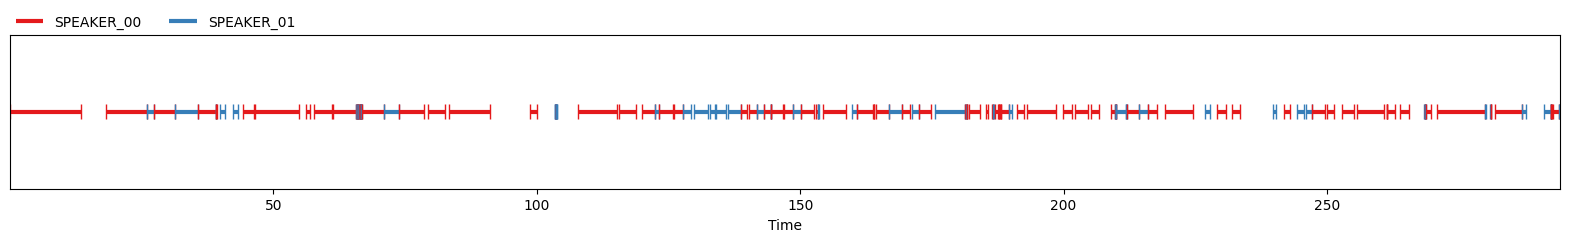

In [124]:
file["finetuned pipeline"]

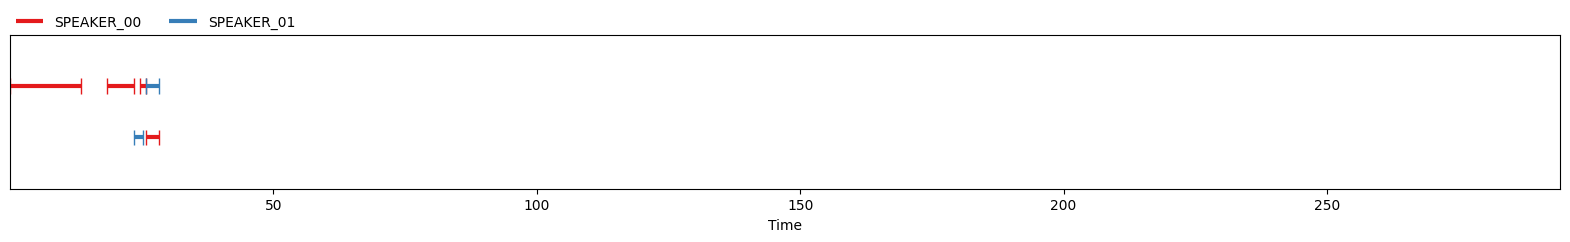

In [125]:
file["annotation"]

In [126]:
finetuned_pipeline.dump_params(Path("./parameters/config.yaml"))

'params:\n  clustering:\n    method: centroid\n    min_cluster_size: 15\n    threshold: 0.6542885015594471\n  segmentation:\n    min_duration_off: 0.0\n    threshold: 0.5029620679588389\n'

## Second training

In [127]:
# model = Model.from_pretrained(Path("./models/trained_model.ckpt"))
# task = pyannote.audio.tasks.SpeakerDiarization(
#     protocol,
#     max_num_speakers=5,
#     batch_size=32,
#     vad_loss="bce"
# )

# model.task = task
# model.prepare_data()
# model.setup()

# model.configure_optimizers = MethodType(configure_optimizers, model)

In [128]:
# monitor, direction = task.val_monitor
# checkpoint = ModelCheckpoint(
#     monitor,
#     mode=direction,
#     save_top_k=1,
#     every_n_epochs=1,
#     save_last=False,
#     save_weights_only=False,
#     filename="{epoch}",
#     verbose=False
# )

# early_stopping = EarlyStopping(
#     monitor=monitor,
#     mode=direction,
#     min_delta=0.0,
#     patience=10,
#     strict=True,
#     verbose=False
# )

# callbacks = [RichProgressBar(), checkpoint, early_stopping]

In [129]:
# trainer = pl.Trainer(
#     callbacks=callbacks,
#     max_epochs=20,
#     gradient_clip_val=0.5
# )

In [130]:
# trainer.fit(model)

In [131]:
# trained_model = checkpoint.best_model_path
# shutil.copy(trained_model, "./models/trained_model.ckpt")

## second finetuning

In [132]:
# pipeline = SpeakerDiarization(
#     segmentation=trained_model,
#     clustering="OracleClustering"
# )

# pipeline.freeze({"segmentation": {"min_duration_off": 0.0}})

# optimizer = Optimizer(pipeline)
# dev_set = list(protocol.development())

# iterations = optimizer.tune_iter(dev_set, show_progress=True)
# best_loss = 1.0
# for i, iteration in enumerate(iterations):
#     print(f"Best segmentation threshold so far: {iteration['params']['segmentation']['threshold']}")
#     if i > 50: break

In [133]:
# best_segm_threshold = optimizer.best_params["segmentation"]["threshold"]

# pipeline = SpeakerDiarization(
#     segmentation=trained_model,
#     embedding=pretrained_pipeline.embedding,
#     embedding_exclude_overlap=pretrained_pipeline.embedding_exclude_overlap,
#     clustering=pretrained_pipeline.klustering,
# )

# pipeline.freeze({
#     "segmentation": {
#         "threshold": best_segm_threshold,
#         "min_duration_off": 0.0
#     },
#     "clustering": {
#         "method": "centroid",
#         "min_cluster_size": 15
#     }
# })

# optimizer = Optimizer(pipeline)
# iterations = optimizer.tune_iter(dev_set, show_progress=False)
# best_loss = 1.0
# for i, iteration in enumerate(iterations):
#     print(f"Best clustering threshold so far: {iteration['params']['clustering']['threshold']}")
#     if i > 50: break 

In [134]:
# best_clust_threshold = optimizer.best_params["clustering"]["threshold"]

# finetuned_pipeline = SpeakerDiarization(
#     segmentation=trained_model,
#     embedding=pretrained_pipeline.embedding,
#     embedding_exclude_overlap=pretrained_pipeline.embedding_exclude_overlap,
#     clustering=pretrained_pipeline.klustering
# )

# finetuned_pipeline.instantiate({
#     "segmentation": {
#         "threshold": best_segm_threshold,
#         "min_duration_off": 0.0
#     },
#     "clustering": {
#         "method": "centroid",
#         "min_cluster_size": 15,
#         "threshold": best_clust_threshold
#     }
# })

In [135]:
# metric = DiarizationErrorRate()

# for file in protocol.test():
#     print(file)
#     file["finetuned pipeline"] = finetuned_pipeline(file)
#     metric(file["annotation"], file["finetuned pipeline"], uem=file["annotated"])

# print(f"Diarization error rate is {100 * abs(metric):.1f}% for the pretrained model")

In [136]:
# file["finetuned pipeline"]

In [137]:
# file["annotation"]

In [138]:
# finetuned_pipeline.dump_params(Path("./parameters/config.yaml"))